In [3]:
from qiskit.circuit.library import UnitaryGate
import numpy as np
from importlib import reload
import unitary_test as unitary_test
reload(unitary_test)
from unitary_test import depol_U_8x8, p_from_target_fidelity, depol_stinespring
target_fidelity = .98
depol_U_bool = False
depol_Pauli_bool = False
depol_QPD = True
if depol_U_bool:
    p = p_from_target_fidelity(target_fidelity)
    U = UnitaryGate(depol_U_8x8(p), label="Depol")
        
elif depol_Pauli_bool:
    p = (4/3)*p_from_target_fidelity(target_fidelity)
    dep_gate = depol_stinespring(p)
        


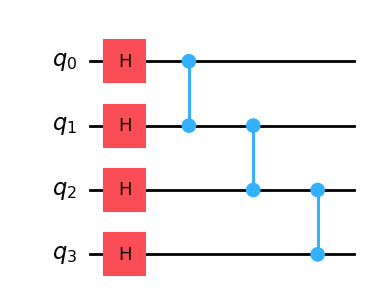

In [4]:
#This builds a linear graph state 0-1-2-3
from qiskit import QuantumCircuit

def make_base_graph():
    qc = QuantumCircuit(4)
    for q in [0,1,2,3]:
        qc.h(q)  
    #qc.cz(3,0)
    for a, b in [(0,1),(1,2),(2,3)]:
        qc.cz(a,b)
    # leave out cz(0,3) here – we’ll insert it via the three methods
    return qc

qc_real = make_base_graph()
qc_real.draw('mpl')

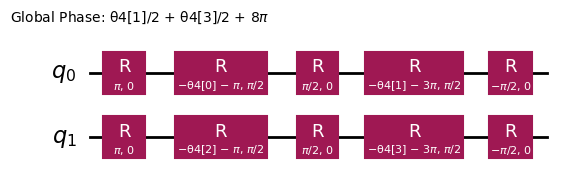

In [5]:
#This builds the cut bell pair factory for one cut bell pair
from qiskit import qpy
from qiskit import transpile
with open("data/one_bell_pair.qpy", "rb") as fd:
    cut_bell_pair_factory1 = qpy.load(fd)[0]
if depol_U_bool:
    cut_bell_pair_factory = QuantumCircuit(6)

    cut_bell_pair_factory.compose(cut_bell_pair_factory1,[2,3], inplace = True)
    cut_bell_pair_factory.compose(U,[2,1,0], inplace = True)
    cut_bell_pair_factory.compose(U,[3,4,5], inplace = True)
elif depol_Pauli_bool:
    cut_bell_pair_factory = QuantumCircuit(8)
    cut_bell_pair_factory.compose(cut_bell_pair_factory1,[3,4], inplace = True)
    cut_bell_pair_factory.compose(dep_gate,[3,0,1,2], inplace=True)
    cut_bell_pair_factory.compose(dep_gate,[4,5,6,7], inplace=True)
else: 
    cut_bell_pair_factory = QuantumCircuit(2)

    cut_bell_pair_factory.compose(cut_bell_pair_factory1,[0,1], inplace = True)

#cut_bell_pair_factory.draw("mpl", fold=False)

qc2 = transpile(cut_bell_pair_factory, basis_gates=['r', 'cz'], optimization_level=3)
qc2.draw('mpl')

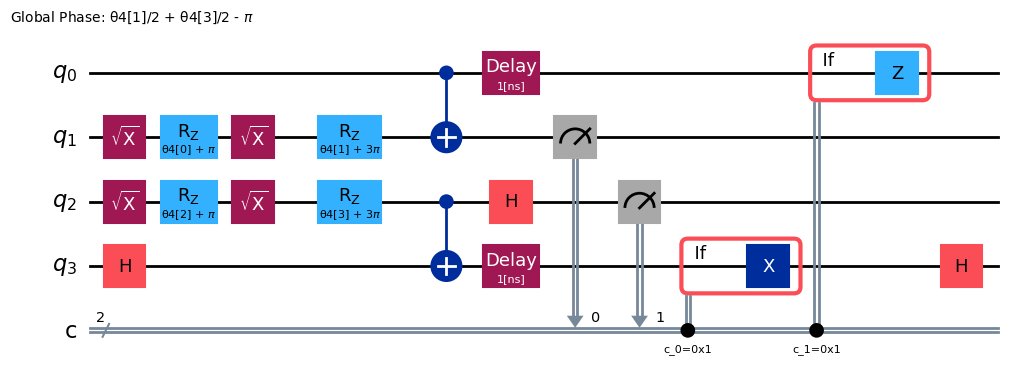

In [6]:
#This puts the cut bell pair factory in a teleportation circuit
if depol_U_bool:
    teleportation_circuit = QuantumCircuit(8,2)
elif depol_Pauli_bool:
    teleportation_circuit = QuantumCircuit(10,2)
else:
    teleportation_circuit = QuantumCircuit(4,2)
#teleportation_circuit.h(2)
#teleportation_circuit.h(1)
#teleportation_circuit.h(0)
#teleportation_circuit.h(3)
teleportation_circuit.h(3)
if depol_U_bool:
    teleportation_circuit.compose(cut_bell_pair_factory,[4,5,1,2,6,7],inplace=True)
elif depol_Pauli_bool:
    teleportation_circuit.compose(cut_bell_pair_factory,[4,5,6,1,2,7,8,9],inplace=True)
else: 
    teleportation_circuit.compose(cut_bell_pair_factory,[1,2],inplace=True)
#teleportation_circuit.h(3)
teleportation_circuit.cx(0,1)
teleportation_circuit.cx(2,3)
teleportation_circuit.h(2)
teleportation_circuit.measure(1,0)
teleportation_circuit.measure(2,1)
teleportation_circuit.delay(1, [0,3], "ns") 
with teleportation_circuit.if_test((teleportation_circuit.clbits[1],1)):
    teleportation_circuit.z(0)
with teleportation_circuit.if_test((teleportation_circuit.clbits[0],1)):
    teleportation_circuit.x(3)
teleportation_circuit.h(3)

teleportation_circuit.draw('mpl')

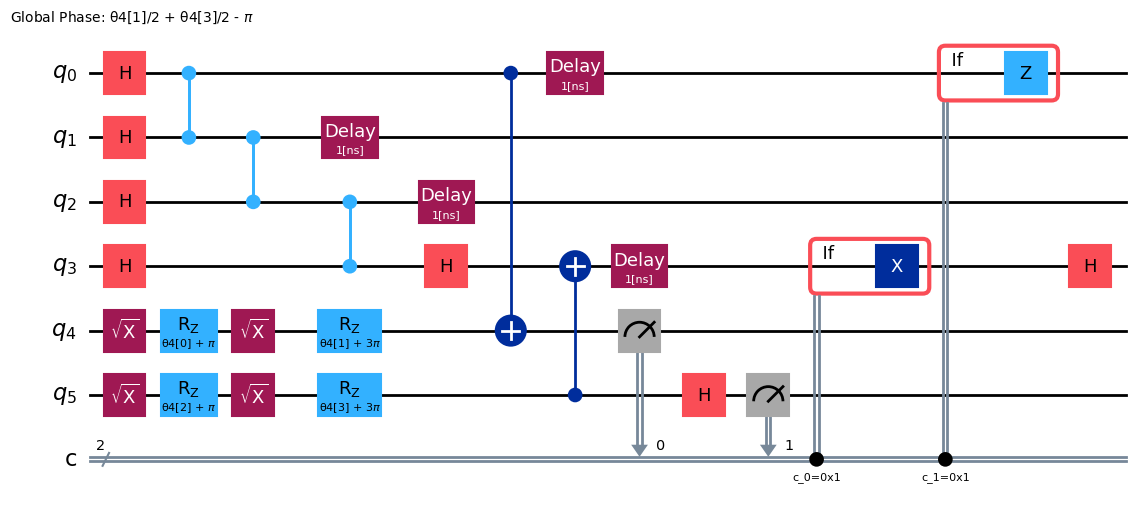

In [7]:
# now put the cut bell pair into the graph state 
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.noise import NoiseModel
from qiskit_aer import AerSimulator
if depol_U_bool:
    cut_graph_state = QuantumCircuit(10,2)
elif depol_Pauli_bool:
    cut_graph_state = QuantumCircuit(12,2)
else: 
    cut_graph_state = QuantumCircuit(6,2)
cut_graph_state.compose(qc_real, [0,1,2,3], inplace=True)
cut_graph_state.delay(1, [1,2], "ns")
if depol_U_bool:
    cut_graph_state.compose(teleportation_circuit, [0,4,5,3,6,7,8,9], [0,1], inplace=True)
elif depol_Pauli_bool:
    cut_graph_state.compose(teleportation_circuit, [0,4,5,3,6,7,8,9,10,11], [0,1], inplace=True)
else: 
    cut_graph_state.compose(teleportation_circuit, [0,4,5,3], [0,1], inplace=True)
cut_graph_state.draw('mpl')
#service = QiskitRuntimeService() 
#backend1 = service.backend("ibm_torino")
#tc = transpile(cut_graph_state, backend=backend1, optimization_level=3)
#tc.draw('mpl')









In [ ]:
#Put your own stuff here -- this is not good practice
from qiskit_ibm_runtime import QiskitRuntimeService
token = "wNB6gtFL0wobt8rFze6UGZp6dLfGRw0nDr2nb1eJHM8x"

QiskitRuntimeService.save_account(
  token=token,
  channel="ibm_cloud", # `channel` distinguishes between different account types.
  instance="crn:v1:bluemix:public:quantum-computing:us-east:a/864c2f593f7d456d815b632b2d616667:714b70bd-14f6-4774-8981-e5ccb9dc6664::", # Optionally copy the instance CRN or name from the Instance section on the dashboard.
  overwrite=True # Only needed if you already have Cloud credentials.
)

In [8]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2 as Estimator #Use this in simulation
#from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator #Use this on real backend
import numpy as np
from qiskit_aer.noise import NoiseModel, thermal_relaxation_error
from qiskit_braket_provider import BraketProvider, BraketLocalBackend
from qiskit.quantum_info import SparsePauliOp

import qiskit_aer; print(qiskit_aer.__version__)

num_qubits = 6#change via number of qubits in circuit

# ---- load QPD parameter tuples ----
thetas = np.loadtxt("data/one_qpd_bell_pair_param_values.txt")
I_LOCC = len(thetas)


observables = {
    "S0":  SparsePauliOp.from_sparse_list([("ZZX", [3,1,0], 1)], num_qubits=num_qubits),
    "S3":  SparsePauliOp.from_sparse_list([("ZZX", [0,2,3], 1)], num_qubits=num_qubits),
    "S03": SparsePauliOp.from_sparse_list([("YZZY", [0,1,2,3], 1)], num_qubits=num_qubits)
}
#-------Simulator setup start here-----------
# Setup simulator and transpile circuit
#run on real noise model
service = QiskitRuntimeService()
hw = service.backend("ibm_torino")
props = hw.properties()
print(props.t1(0), props.t2(0))
# 2) Aer simulator with Torino noise (keeps dynamics by NOT copying coupling_map)
noise = NoiseModel.from_backend(hw)
#This applies 
tau_ns = 1
tau_s  = tau_ns * 1e-9
for q in range(num_qubits):
    T1 = props.t1(q)
    T2 = props.t2(q)
    if T1 is None or T2 is None or T1 <= 0:
        continue
    T2_eff = min(T2, 2.0*T1)  # enforce T2 <= 2*T1
    err = thermal_relaxation_error(T1, T2_eff, tau_s)
    noise.add_quantum_error(err, "delay", [q])
backend = AerSimulator(
    noise_model=noise,
    basis_gates=noise.basis_gates,
    coupling_map=None,          # keep dynamic-circuit-friendly
)
#-------Simulator setup end here-----------
#-------Real computer setup start here-----------
provider = BraketProvider()
print(provider.backends())
backend1 = provider.get_backend("Emerald")
#-------Real computer setup end here-----------
qct = transpile(cut_graph_state,backend)

layout=qct.layout
observables["S0"] = observables["S0"].apply_layout(layout)
observables["S3"] = observables["S0"].apply_layout(layout)
observables["S03"] = observables["S0"].apply_layout(layout)
exact_estimator = Estimator.from_backend(backend, options={ "run_options": {"shots": 1024}}) #Use for simulator
#exact_estimator = Estimator(backend, options={"default_shots": 1024, "resilience_level": 0}) #Use for real computer


isa_circuit = qct



# Prepare results data structure
results_dict = {}

for i in range(I_LOCC):
    theta = thetas[i]
    print(i)
    results_dict[i] = {}

    params = list(isa_circuit.parameters)
    bind_map = dict(zip(params, theta))
    bound = isa_circuit.assign_parameters(bind_map, inplace=False)
    
    for label, observable in observables.items():
        pub = (isa_circuit, observable, theta)
        job = exact_estimator.run([pub])
        result = job.result()
        exact_value = float(result[0].data.evs)
        variance = (result[0].data.stds)
        results_dict[i][label] = exact_value
        print("label", label, exact_value, variance)
    


0.17.0
0.00018807498322864067 0.0001837892044487827
[BraketBackend[Ankaa-3], BraketBackend[Aria 1], BraketBackend[Aria 2], BraketBackend[Emerald], BraketBackend[Forte 1], BraketBackend[Forte Enterprise 1], BraketBackend[Garnet], BraketBackend[SV1], BraketBackend[dm1]]
0
label S0 0.948008261797657 0.0
label S3 0.9550781968695182 0.0
label S03 0.9410408857676151 0.0
1
label S0 0.23507982770584207 0.0
label S3 0.23294732965752013 0.0
label S03 0.2318181647154135 0.0
2
label S0 0.22875148214866048 0.0
label S3 0.2348844980648587 0.0
label S03 0.23275157998705598 0.0
3
label S0 -1.4968322553414903e-09 0.0
label S3 -1.0497978869058815e-07 0.0
label S03 -3.738065963424079e-08 0.0
4
label S0 -3.1354140864930237e-10 0.0
label S3 -1.0360903957457315e-09 0.0
label S03 -4.6480562021527415e-07 0.0
5
label S0 -3.5668409215810924e-07 0.0
label S3 3.1911393433133105e-07 0.0
label S03 1.0658926699825906e-07 0.0
6
label S0 -5.03113395200503e-10 0.0
label S3 -1.072603594662575e-07 0.0
label S03 -1.066627

In [9]:

mu = (4*target_fidelity -1) / 3 

expect_bell = {label: 0.0 for label in next(iter(results_dict.values())).keys()}
expect_id   = {label: 0.0 for label in next(iter(results_dict.values())).keys()}
expect      = {label: 0.0 for label in next(iter(results_dict.values())).keys()}

# both masks are {0,1,2} since we measured 3 classical bits [b2,b1,b0]


for i, result in results_dict.items():
    for label in result:
        if i < 3:
            expect_bell[label] += (2/9) * result[label]
        elif i < 5:
            expect_bell[label] += (-1/6) * result[label]
        if depol_QPD and i in (3, 4, 5, 6):
            expect_id[label] += 0.25 * result[label]

for label in expect:
    if depol_QPD:
        expect[label] = mu * (3.0 * expect_bell[label]) + (1.0 - mu) * expect_id[label]
    else:
        expect[label] = 3 * expect_bell[label]

# 6) Final entanglement witness = ⟨S0⟩ + ⟨S3⟩

print(f"⟨S0⟩ = {expect['S0']:.5f}")
print(f"⟨S3⟩ = {expect['S3']:.5f}")
print(f"⟨S03⟩ = {expect['S03']:.5f}")
witness = (1-expect['S3']-expect['S0']-expect['S03'])/4.0
print(f"Entanglement witness = {witness:.5f}")

⟨S0⟩ = 0.91613
⟨S3⟩ = 0.92331
⟨S03⟩ = 0.91209
Entanglement witness = -0.43788
